# Convolutional Neural Network 모델 정의

In [ ]:
import torch
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(device)

cpu


In [ ]:
layer = nn.Conv2d(in_channels=4,out_channels=2,kernel_size=3,stride=1,padding=0)
print(layer)

Conv2d(4, 2, kernel_size=(3, 3), stride=(1, 1))


In [ ]:
# Layer객체.weight, Layer객체.bias => Layer의 weight,bias를 조회
layer.weight.shape # ->[out_chaneels=>필터의개수,in_channels,height,width`]

torch.Size([2, 4, 3, 3])

In [ ]:
layer.bias.shape

torch.Size([2])

In [ ]:
input_data = torch.ones(1,4,3,3) # 데이터 개수:1 h:3, w:3, ch:3



In [ ]:
# 채널별로 연산
ch1 = torch.sum(input_data[0,0] *layer.weight[0,0])
ch2 = torch.sum(input_data[0,1]*layer.weight[0,1])
ch3 = torch.sum(input_data[0,2]*layer.weight[0,2])
ch4 = torch.sum(input_data[0,3]*layer.weight[0,3])
# 채널별 합계 +bias
result = ch1+ ch2+ch3+ch4 + layer.bias[0].item()
result

tensor(-0.5512, grad_fn=<AddBackward0>)

In [ ]:
# 채널별로 연산
ch1 = torch.sum(input_data[0,0] *layer.weight[1,0])
ch2 = torch.sum(input_data[0,1]*layer.weight[1,1])
ch3 = torch.sum(input_data[0,2]*layer.weight[1,2])
ch4 = torch.sum(input_data[0,3]*layer.weight[1,3])
# 채널별 합계 +bias
result3 = ch1+ ch2+ch3+ch4 + layer.bias[1].item()
result3

tensor(-0.2599, grad_fn=<AddBackward0>)

In [ ]:
result2= layer(input_data)
result2

tensor([[[[-0.5512]],

         [[-0.2599]]]], grad_fn=<ConvolutionBackward0>)

# MNIST

In [8]:
pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
from pathlib import Path
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, datasets, transforms
from torchinfo import summary
from module.data import load_mnist_dataset, load_fashion_mnist_dataset
from module.train import fit

import matplotlib.pyplot as plt
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print(device)
# 1에폭정도만 돌려보고 그이후에 gpu 코렙을 이용한다

cuda


## Data 준비

In [11]:
DATASET_ROOT_PATH ='datasets'
MODEL_SAVE_PATH='models'
import os
os.makedirs(DATASET_ROOT_PATH,exist_ok=True)
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)
N_EPOCH=20
BATCH_SIZE=128
LR= 0.001


In [12]:
train_loader = load_fashion_mnist_dataset(DATASET_ROOT_PATH, BATCH_SIZE,True)
test_loader = load_fashion_mnist_dataset(DATASET_ROOT_PATH,BATCH_SIZE,False)

100%|██████████| 26421880/26421880 [00:01<00:00, 15965869.17it/s]


Extracting datasets/FashionMNIST/raw/train-images-idx3-ubyte.gz to datasets/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 272660.34it/s]


Extracting datasets/FashionMNIST/raw/train-labels-idx1-ubyte.gz to datasets/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5117471.29it/s]


Extracting datasets/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to datasets/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 23938222.83it/s]

Extracting datasets/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to datasets/FashionMNIST/raw



In [13]:
train_loader.dataset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: datasets
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

## CNN 모델 정의

In [14]:
# CNN - Conv Layer: filter의 개수(out_channel)는 뒤로갈수록 크게 잡는다
#                      출력결과(feature map ) 의 size(height,width)는 줄여나간다.
# Conv block:
#     1. Conv + ReLU +MaxPooling
#     2. Conv + Batch Norm + ReLU + MaxPooling
#     3. Conv + Batch Norm + ReLU + Dropout + MaxPooling
class FMnistCNNModel(nn.Module):

    def __init__(self):
        super().__init__()
        # 3 X 3 필터, stride = 1, padding = 1 => input size == outputsize
        self.block1= nn.Sequential(
            nn.Conv2d(1,32, kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(32),# 노멀라이즈
            nn.ReLU(), # 비선형
            nn.Dropout2d(p=0.3),
            nn.MaxPool2d(kernel_size=2,stride=2)  # kernel_size 와 stride가 동일할 경우 stride는 생략가능
            )
        self.block2 = nn.Sequential(
            nn.Conv2d(32,64,kernel_size=3, padding='same'),
            nn.BatchNorm2d(64),# 노멀라이즈
            nn.ReLU(), # 비선형
            nn.Dropout2d(p=0.3),
            nn.MaxPool2d(kernel_size=2)
            )
        self.block3 = nn.Sequential(
            nn.Conv2d(64,128,kernel_size=3, padding='same'),
            nn.BatchNorm2d(128),# 노멀라이즈
            nn.ReLU(), # 비선형
            nn.Dropout2d(p=0.3),
            nn.MaxPool2d(kernel_size=2)
            )
        self.output_block = nn.Sequential(
            nn.Linear(128*3*3,512),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(512,10)
        )

    def forward(self,X):
        out = self.block1(X)
        out = self.block2(out)
        out = self.block3(out) # 특성 추출
        out = nn.Flatten()(out)
        out = self.output_block(out) # 추론
        return out

In [15]:
model = FMnistCNNModel().to(device)
summary(model, (BATCH_SIZE, 1, 28,28))

Layer (type:depth-idx)                   Output Shape              Param #
FMnistCNNModel                           [128, 10]                 --
├─Sequential: 1-1                        [128, 32, 14, 14]         --
│    └─Conv2d: 2-1                       [128, 32, 28, 28]         320
│    └─BatchNorm2d: 2-2                  [128, 32, 28, 28]         64
│    └─ReLU: 2-3                         [128, 32, 28, 28]         --
│    └─Dropout2d: 2-4                    [128, 32, 28, 28]         --
│    └─MaxPool2d: 2-5                    [128, 32, 14, 14]         --
├─Sequential: 1-2                        [128, 64, 7, 7]           --
│    └─Conv2d: 2-6                       [128, 64, 14, 14]         18,496
│    └─BatchNorm2d: 2-7                  [128, 64, 14, 14]         128
│    └─ReLU: 2-8                         [128, 64, 14, 14]         --
│    └─Dropout2d: 2-9                    [128, 64, 14, 14]         --
│    └─MaxPool2d: 2-10                   [128, 64, 7, 7]           --
├─Sequent

In [16]:
# 학습
save_path= os.path.join(MODEL_SAVE_PATH, 'fmnist_cnn_model.pt')
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = LR)

result = fit(train_loader,test_loader,model,loss_fn, optimizer, N_EPOCH,save_best_model=True,save_model_path=save_path,early_stopping=True,device= device,mode='multi')

Epoch[1/20] - Train loss: 0.33240 Train Accucracy: 0.87602 || Validation Loss: 0.35922 Validation Accuracy: 0.86490
저장: 1 - 이전 : inf, 현재: 0.35921878169609023
Epoch[2/20] - Train loss: 0.27182 Train Accucracy: 0.89927 || Validation Loss: 0.30447 Validation Accuracy: 0.88840
저장: 2 - 이전 : 0.35921878169609023, 현재: 0.3044724077740802
Epoch[3/20] - Train loss: 0.23093 Train Accucracy: 0.91452 || Validation Loss: 0.26698 Validation Accuracy: 0.90410
저장: 3 - 이전 : 0.3044724077740802, 현재: 0.2669836535483976
Epoch[4/20] - Train loss: 0.22674 Train Accucracy: 0.91257 || Validation Loss: 0.26860 Validation Accuracy: 0.89950
Epoch[5/20] - Train loss: 0.20627 Train Accucracy: 0.92348 || Validation Loss: 0.25316 Validation Accuracy: 0.90780
저장: 5 - 이전 : 0.2669836535483976, 현재: 0.25316310098654105
Epoch[6/20] - Train loss: 0.19299 Train Accucracy: 0.92820 || Validation Loss: 0.24428 Validation Accuracy: 0.91080
저장: 6 - 이전 : 0.25316310098654105, 현재: 0.24428392182799835
Epoch[7/20] - Train loss: 0.19389 

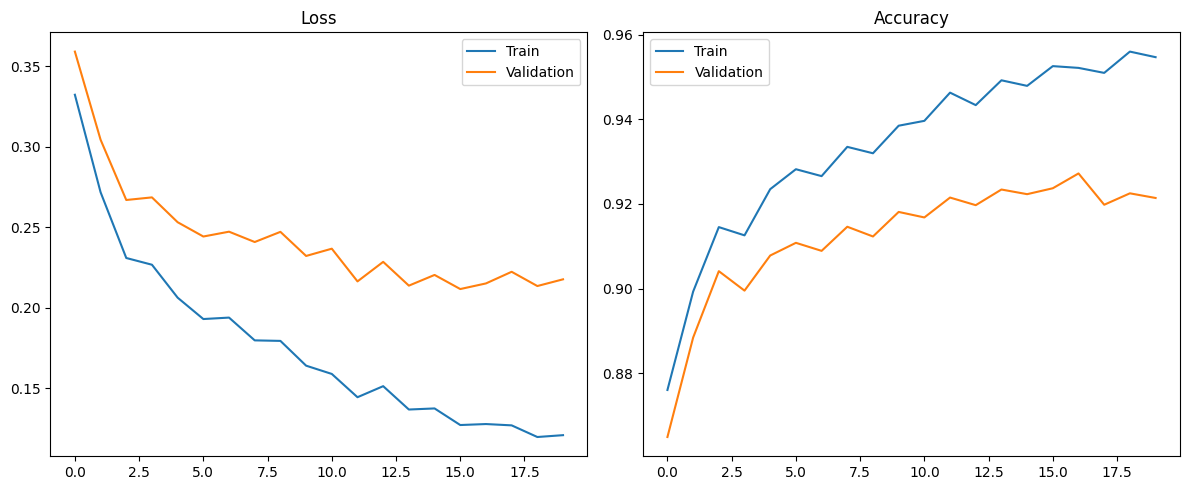

In [18]:
from module.utils import plot_fit_result

plot_fit_result(*result)

## Train

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
save_path= os.path.join(MODEL_SAVE_PATH,'fmnist_cnn_model.pt')
target_path='/content/models/fmnist_cnn_model2.pt'

In [27]:
import shutil
shutil.copyfile(save_path,target_path)

'/content/models/fmnist_cnn_model2.pt'